Motivation: Every player starts out as "average", so we've got a handful of schools dominating bad conferences bubbling up in the rankings. We know things about players before they start on a team that we can use to start them with a better prior.

It'd be ideal to get something like their recruiting ratings, but that seems like a lot of work. Instead, let's assume teams usually recruit the same type of players - kinda true (prime counter-example: Penny Hardaway massively upping Memphis's recruiting when he was hired).

## Method

Figure out a different prior for each _team's_ players to start with

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

from individual_players import build_combined_df

In [3]:
league = "womens"

In [4]:
player_ratings = pd.read_csv(f"./data/{league}_player_ratings.csv", index_col=0)
player_info = pd.read_csv(f"./data/{league}_player_info.csv", index_col="player_id")
player_ratings = player_ratings.merge(
    player_info, left_index=True, right_index=True, how="left"
)
defense_ratings = pd.read_csv(
    f"./data/{league}_player_ratings_defense.csv", index_col=0
)
player_ratings = player_ratings.merge(
    defense_ratings, left_index=True, right_index=True, suffixes=("", "_defense")
).assign(net_vpp=lambda _: _.vpp - _.vpp_defense)

all_performances = build_combined_df(league, verbose=False)
possessions = all_performances.groupby('player_id').agg({"n_possessions": "sum"})

player_ratings = (
    player_ratings.merge(possessions, left_index=True, right_index=True)
    .assign(total_value=lambda _: _.vpp * _.n_possessions)
)

In [5]:
teams = (
    player_ratings
    .groupby("team_id")
    .agg({
        "total_value": "sum",
        "n_possessions": "sum",
    })
    .assign(vpp=lambda _: _.total_value / _.n_possessions)
)

In [6]:
player_ratings = (
    player_ratings.merge(
        teams, left_on="team_id", right_index=True, suffixes=("", "_team")
    )
    .assign(
        value_without_this_player=lambda _: _.total_value_team - _.total_value,
        possessions_without_this_player=lambda _: _.n_possessions_team - _.n_possessions,
    )
    .assign(
        other_players_vpp=lambda _: _.value_without_this_player
        / _.possessions_without_this_player,
        vpp_diff=lambda _: _.vpp - _.other_players_vpp,
    )
)


In [7]:
import numpy as np

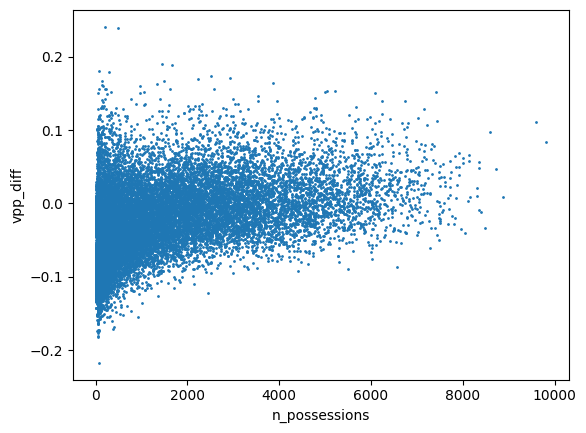

In [8]:
player_ratings.plot.scatter("n_possessions", "vpp_diff", s=1);

In [9]:
std_by_sample_size = (
    player_ratings.assign(
        percentile=lambda _: (
            np.argsort(_.n_possessions).argsort() / len(_) * 100
        ).astype(int),
    )
    .groupby("percentile")
    .agg({"vpp_diff": "std", "n_possessions": "median"})
    .reset_index()
    .rename(columns={"vpp_diff": "value_std"})
)


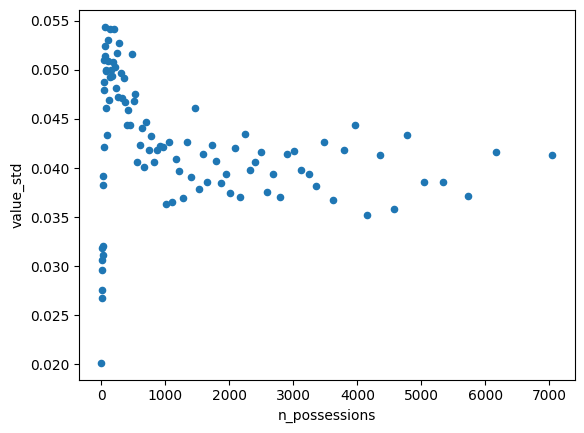

In [10]:
std_by_sample_size.plot.scatter('n_possessions', 'value_std');

In [11]:
# So it's pretty flat, I think that makes sense
# Players that play higher #s of possessions aren't much more likely to 
# differ from their team's average player?

# I think the low part is because players with very few possessions don't 
# get ta chance to drift far from the average, so they have a low deviation
# We should probably cut off a min #s possessions here
vpp_var = std_by_sample_size.value_std.median() ** 2

In [12]:
def _update_rating(
    team_mu: float, team_var: float, player_vpp
) -> tuple[float, float]:
    new_mu = (team_mu * vpp_var + player_vpp * team_var) / (
        vpp_var + team_var
    )
    new_var = 1 / ((1 / team_var + 1 / vpp_var))
    return new_mu, new_var

In [13]:
from collections import defaultdict

In [14]:
team_ratings = defaultdict(lambda: (teams.vpp.mean(), teams.vpp.var()))

In [15]:
for player in player_ratings.itertuples():
    team_ratings[player.team_id] = _update_rating(
        *team_ratings[player.team_id], player.vpp
    )


In [16]:
team_priors = pd.DataFrame(team_ratings).T.rename(columns={0: "vpp", 1: "vpp_var"})

In [17]:
team_priors.to_csv(f"./data/{league}_team_priors.csv")

For women's teams, this seems pretty logical.
Top teams are UConn, Tennessee, Baylor
Men's is a bit sus. Duke is #1, but Gonzaga is #2, St. Mary's is also up there
My current theory is that most of the best mens players leave early,
which doesn't let them raise their ratings very much because they only get 1 year of possessions.

This would cause schools that more often have solid 4-year players pass schools with more talented but 1-and-done. I'm hoping that these still serve as useful priors to help us make faster updates to the best players. But I'm definitely worried this would take multiple rounds of team priors->regular update->new team priors, and have a bit more itch to get individual player priors from recruiting ratings

In [18]:
for team in team_priors.sort_values('vpp', ascending=False).itertuples():
    print(f"{team.vpp:.03f} {team.vpp_var:.05f} https://www.espn.com/{league}-college-basketball/team/_/id/{team.Index}/")

0.123 0.00004 https://www.espn.com/womens-college-basketball/team/_/id/41/
0.115 0.00004 https://www.espn.com/womens-college-basketball/team/_/id/2633/
0.115 0.00004 https://www.espn.com/womens-college-basketball/team/_/id/2579/
0.114 0.00004 https://www.espn.com/womens-college-basketball/team/_/id/239/
0.111 0.00003 https://www.espn.com/womens-college-basketball/team/_/id/97/
0.104 0.00004 https://www.espn.com/womens-college-basketball/team/_/id/2390/
0.102 0.00004 https://www.espn.com/womens-college-basketball/team/_/id/120/
0.101 0.00004 https://www.espn.com/womens-college-basketball/team/_/id/87/
0.101 0.00044 https://www.espn.com/womens-college-basketball/team/_/id/126864/
0.100 0.00004 https://www.espn.com/womens-college-basketball/team/_/id/2294/
0.099 0.00004 https://www.espn.com/womens-college-basketball/team/_/id/152/
0.099 0.00004 https://www.espn.com/womens-college-basketball/team/_/id/24/
0.099 0.00004 https://www.espn.com/womens-college-basketball/team/_/id/130/
0.098 0.0